**Import the packages**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np

**Read the Dataset**

In [ ]:
data=pd.read_csv("demand_forecasting_data.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


There is no null values in the dataset, and the Store,item & sales are in INT datatype no need to change the type of the columns. 'date' Column alone needs to be converted as Datetime type.

**Convert the column 'date' to Datetime Object and sort the data by date**

In [ ]:
data['date']=pd.to_datetime(data['date'])
data=data.sort_values(by='date')

**Drop the store Column Hence it not required to build the model**

In [ ]:
data.drop(columns=['store'],inplace=True)


**Plotting the each Products**

In [ ]:
data1=data
data1['year']=data['date'].dt.strftime('%Y')
data1['month']=data['date'].dt.strftime('%m')

In [ ]:
data1.month=data1.month.astype(int)
data1.year=data1.year.astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same argumen

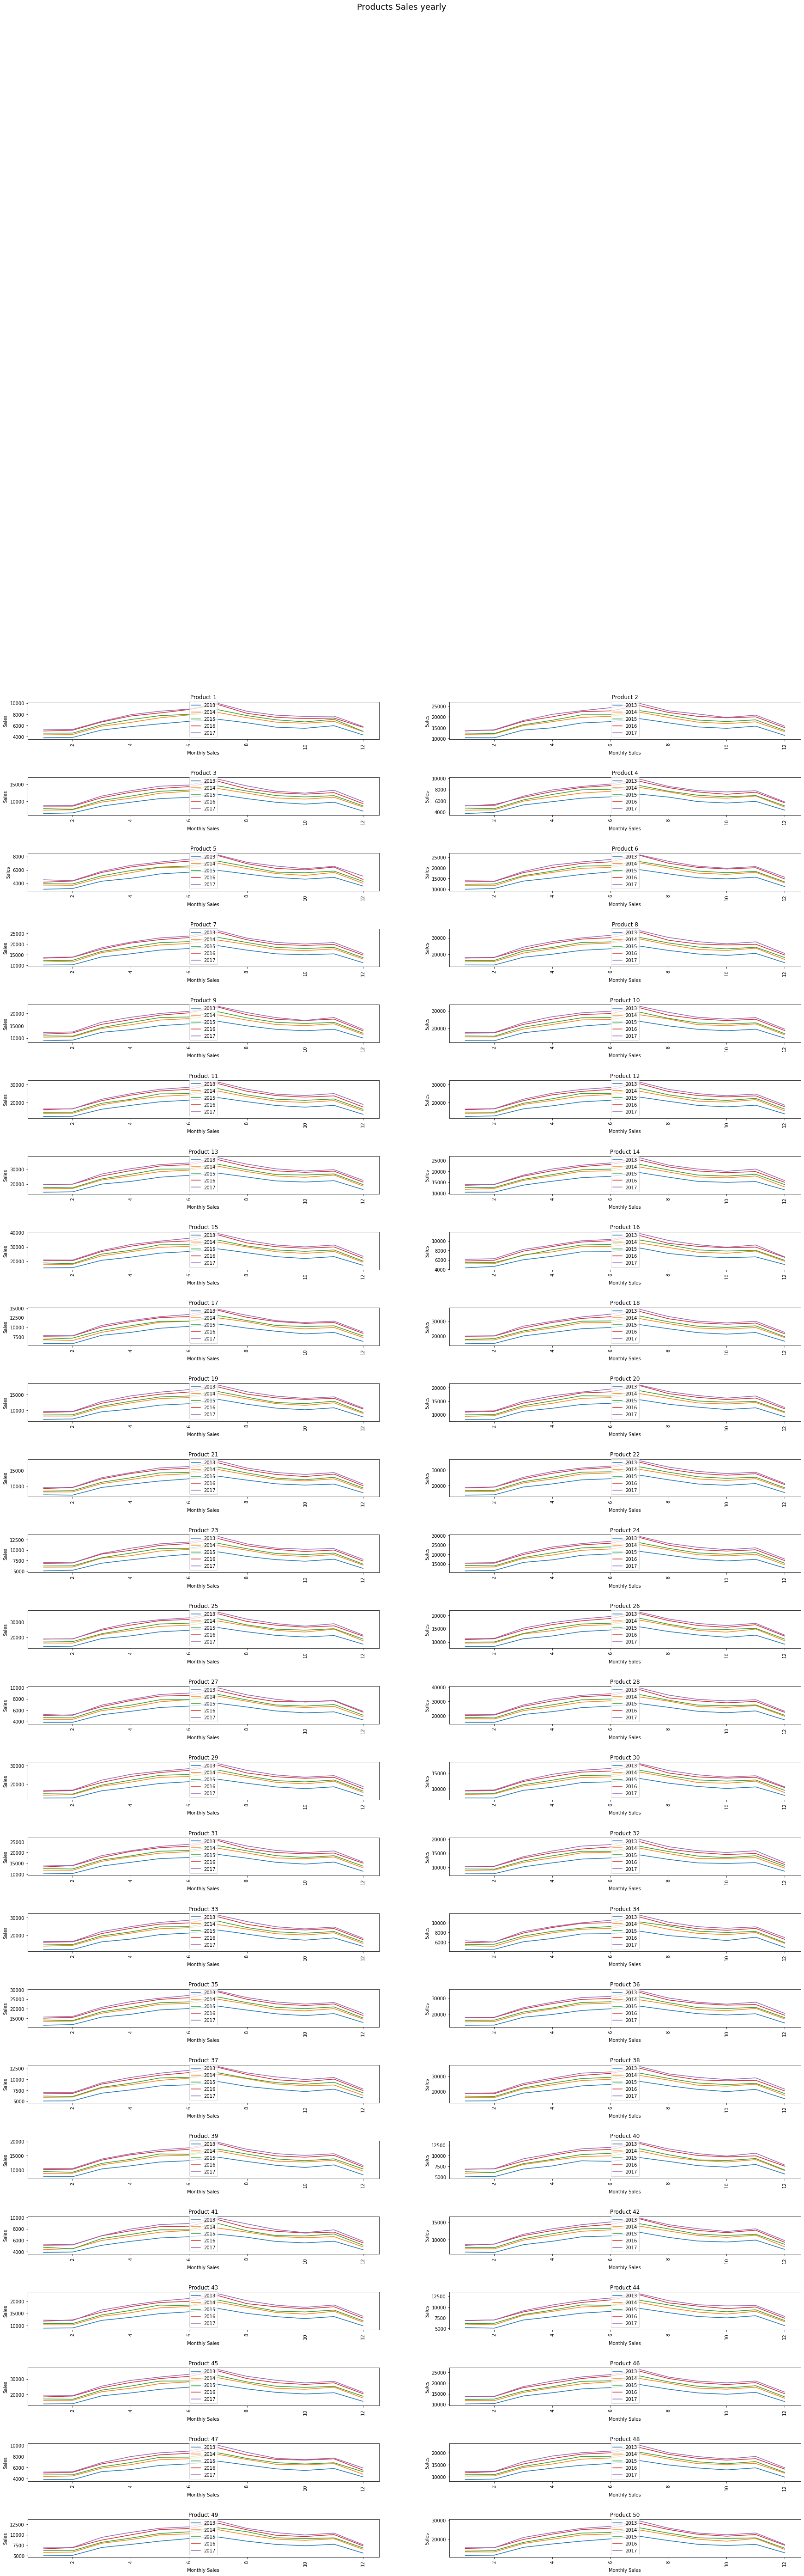

In [ ]:
plt.figure(figsize=(30, 300))
plt.subplots_adjust(hspace=1)
plt.suptitle("Products Sales yearly", fontsize=18, y=0.95)
plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

plt_cnt=0
for i in range(1,51):
  for j in range(2013,2018):
      d1=data1[(data1['year']==j) & (data1['item']==i)]
      d2=d1.groupby(['month'])['sales'].sum()
      d2=d2.to_frame().reset_index()
      x=d2['month']
      y=d2['sales']
      ax = plt.subplot(100,2,plt_cnt+1)
      ax.set_title("Product "+str(i)+"")
      ax.set_xlabel("Monthly Sales")
      ax.set_ylabel("Sales")
      plt.xticks(rotation=90)
      plt.plot(x,y,label=str(j))
      leg = plt.legend(loc='best')
  plt_cnt+=1

From the Above Chart, we can see that all the Item following the Trend, and the Sales increases year-on-year.

**Lets Create the Indiviual DataFrame for each Items.**

In [ ]:
data_list=[]
for item in range(1,51):
  data_1=data[data['item']==item]
  #We removed the Store Column Already, now we group the sales by date.
  data_1=(data_1.groupby(['date','item'],sort=False)['sales'].sum()).reset_index()
  #Lets Find the Rolling Sum of 90 Days, and it as new Column 'sales_90'
  data_1['sales_90']=data_1['sales'].rolling(90).sum()
  data_1['sales_90']=data_1['sales_90'].shift(-90)
  # Lets Encode the Date
  data_1['day_of_month']=data_1['date'].dt.day
  data_1['day_of_week']=data_1['date'].dt.day_of_week
  data_1['day_of_year']=data_1['date'].dt.day_of_year
  data_1['quatar_of_the_year']=data_1["date"].dt.quarter
  data_1['month']=data_1['date'].dt.month
  data_1['year']=data_1['date'].dt.year
  #Drop the Row if contains any NaN value
  data_1.dropna(inplace=True)
  data_list.append(data_1)

We Added new Column 'sales_90' with the Rolling Sum of 90 Days sales. We are going to predict the Next three months sales, Hence we are using the 'sales_90' as target instead of 'sales'.

**Spliting the Training and Test data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train_list=[]
X_test_list=[]
y_train_list=[]
y_test_list=[]
features=['day_of_month','day_of_week','day_of_year', 'quatar_of_the_year', 'month', 'year']
for dt in data_list:
  x=dt[features]
  y=dt['sales_90']
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
  X_train_list.append(X_train)
  X_test_list.append(X_test)
  y_train_list.append(y_train)
  y_test_list.append(y_test)

**Scaling the Data**

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
for i in range(0,len(X_train_list)):
  X_train_list[i] = sc.fit_transform(X_train_list[i]) 
for i in range(0,len(X_test_list)):
  X_test_list[i] = sc.transform(X_test_list[i])
  

**In the above plot for the Product sales data for all products, we see that There is no Linear relationship in the data. So, We will try building the models using DecisionTree Reggression,RandomForest Regression and XGBoost Regression**

**DecisionTree Regression**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
def dt_model(X_train,y_train,X_test,y_test):
  dt_best_depth=pd.DataFrame(columns=['Cross_val','Learning_rate'])
  for i in range(1,21):
    model = DecisionTreeRegressor(max_depth = i) # initialise the model
    model.fit(X_train,y_train) #train the model
    # scoring the model - r2 squared
    dt_best_depth.loc[model.score(X_test, y_test)]=[model.score(X_test, y_test),i]
    print("Max Depth : ", i, " Train score : ", model.score(X_train,y_train)," Test Score: ",model.score(X_test, y_test))
    dt_best_depth
  best_depth=dt_best_depth.loc[dt_best_depth.Cross_val.max()][1]
  print("best_depth:",best_depth)
  descision_tree_model=DecisionTreeRegressor(max_depth=int(best_depth))
  descision_tree_model.fit(X_train,y_train)
  descision_tree_model.score(X_test,y_test)
  return descision_tree_model

****

**RandomForest Regression**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def rf_model(feature_count,X_train,y_train,X_test,y_test):
  max_dpth=round(np.log2(feature_count))
  random_forest_model = RandomForestRegressor(n_estimators = 100,max_depth=max_dpth,max_features="sqrt")
  #log(No.of.Features)/log(2) => Max Depth.
  random_forest_model.fit(X_train, y_train)
  random_forest_model.score(X_test,y_test)
  return random_forest_model

**XGBoost Regression**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
def xb_model(X_train,y_train,X_test,y_test):
  xgb_best_lr=pd.DataFrame(columns=['Cross_val','Learning_rate'])
  for lr in [0.01,0.02,0.03,0.04,0.05,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
    model = xgb.XGBRegressor(learning_rate = lr, n_estimators=100,verbosity = 0) # initialise the model
    model.fit(X_train,y_train) #train the model
    print("Learning rate : ", lr, " Train score : ", model.score(X_train,y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train, y_train, cv=10)))
    cross_val=round(np.mean(cross_val_score(model, X_train, y_train, cv=10)),2)
    xgb_best_lr.loc[cross_val]=[cross_val,lr]
  best_learn_rate=xgb_best_lr.loc[xgb_best_lr.Cross_val.max()][1]
  print('Best_Learn_Rate: ',best_learn_rate) 
  xgb_model = xgb.XGBRegressor(learning_rate = best_learn_rate,n_estimators=100, verbosity = 0)
  xgb_model.fit(X_train,y_train) 
  xgb_model.score(X_test, y_test) 
  return xgb_model

**Function to Evaluate the Models and Get the Best Model Based on R2 Score**

In [ ]:
from sklearn.metrics import r2_score

def get_models_r2(model_list,X_test,y_test):
  try:
    r2_score_list={}
    #Compute R2 for the all the models
    print("Compute R2 for the all the models")
    for i in model_list:
      y_pred = model_list[i].predict(X_test)
      r2_score_list[i]=r2_score(y_test,y_pred)
    return r2_score_list
  
  except Exception as e:
    print(str(e))
  

**Lets Build the Models and find which is best among themselves based on R2 Score.**

In [ ]:
def build_all_models(item,features,X_train,y_train,X_test,y_test):
  try:
    model_list={}
    print("Building Decision Tree Model")
    model_list["DecisionTreeRegressor"]=dt_model(X_train,y_train,X_test,y_test)
    print("Building RandomForest Model")
    model_list["RandomForestRegressor"]=rf_model(len(features),X_train,y_train,X_test,y_test)
    print("Building XGBoost Model")
    model_list["XGBRegressor"]=xb_model(X_train,y_train,X_test,y_test)

    r2_score_list=get_models_r2(model_list,X_test,y_test)
    
    #r2_score_list= r2_score_list.sort_values(ascending=False)
    sorted(r2_score_list.items(), key =
             lambda kv:(kv[1], kv[0]))
    keys_list = list(r2_score_list)
    print("\n\n******************************************************")
    print("Best Model based on R2_score is : ",keys_list[0], " and its R2_Score is ",str(r2_score_list[keys_list[0]]))
    print("\n******************************************************")

    first=1
    result_data=pd.DataFrame(columns=['item','Model_name','Model','R2_Score','is_Best_model'])

    for key in r2_score_list.keys():   
      if first==len(r2_score_list.keys()):
        val={
            'item':item,
             'Model_name':key,
             'Model':model_list[key],
             'R2_Score':r2_score_list[key],
             'is_Best_model':'Yes'
          }
        result_data= result_data.append(val,ignore_index = True)
      else:
        val={
            'item':item,
             'Model_name':key,
             'Model':model_list[key],
             'R2_Score':r2_score_list[key],
             'is_Best_model':'No'
          }
        result_data=result_data.append(val,ignore_index = True)        
      first+=1
    return result_data
  except Exception as error:
    print(error)



**Lets Build the Models and find which is best Among ThemSelves.**

In [ ]:
result=pd.DataFrame(columns=['item','Model_name','Model','R2_Score','is_Best_model'])
item,features,X_test,y_test

for item in range(1,51):
  # Build All Models and get the Best model based on R2 Score.
  result_data=build_all_models(item,features,X_train_list[item-1],y_train_list[item-1],X_test_list[item-1],y_test_list[item-1]) 
  result=result.append(result_data,ignore_index=True)

  


Building Decision Tree Model
Max Depth :  1  Train score :  0.3393871333700005  Test Score:  -0.13377041253038002
Max Depth :  2  Train score :  0.5549890052138049  Test Score:  0.17346728275149736
Max Depth :  3  Train score :  0.7628696347926831  Test Score:  0.4406786761982723
Max Depth :  4  Train score :  0.8627182438791676  Test Score:  0.5548934756750049
Max Depth :  5  Train score :  0.9280435058497132  Test Score:  0.8535520602579885
Max Depth :  6  Train score :  0.9702495089452078  Test Score:  0.913819375215446
Max Depth :  7  Train score :  0.9851948586876899  Test Score:  0.9267429495979593
Max Depth :  8  Train score :  0.993699742904133  Test Score:  0.9342406817306762
Max Depth :  9  Train score :  0.9978099155539336  Test Score:  0.9353906320139285
Max Depth :  10  Train score :  0.9992809506405333  Test Score:  0.936367772939324
Max Depth :  11  Train score :  0.9997937268742917  Test Score:  0.9371389353959813
Max Depth :  12  Train score :  0.999927061105636  Test 

In [ ]:
result

,item,Model_name,Model,R2_Score,is_Best_model
0,1,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=20),0.937333,No
1,1,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=3, max_featur...",0.426738,No
2,1,XGBRegressor,"XGBRegressor(learning_rate=0.5, verbosity=0)",0.943878,Yes
3,2,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=16),0.937112,No
4,2,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=3, max_featur...",0.469401,No
...,...,...,...,...,...
145,49,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=3, max_featur...",0.432305,No
146,49,XGBRegressor,"XGBRegressor(learning_rate=0.2, verbosity=0)",0.927393,Yes
147,50,DecisionTreeRegressor,DecisionTreeRegressor(max_depth=12),0.939959,No
148,50,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=3, max_featur...",0.460712,No


In the above Dataframe, has the data of the Item wise Model details and its R2 Score.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


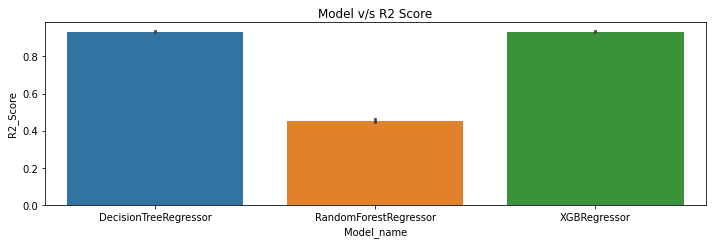

In [ ]:
result_x=result['Model_name']
result_y=result['R2_Score']
plt.title('Model v/s R2 Score')
plt.xlabel('Models')
plt.ylabel('R2 Score')
sns.barplot(result_x,result_y)

From the above plot we see that the XGBRegressor & DecisionTree Regressor are having good R2 Scores among all the Items.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


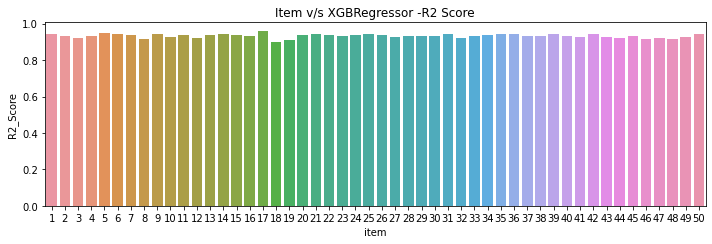

In [ ]:
result_x=result.item[result['Model_name']=='XGBRegressor']
result_y=result.R2_Score[result['Model_name']=='XGBRegressor']
plt.title('Item v/s XGBRegressor -R2 Score')
plt.xlabel('Item')
plt.ylabel('R2 Score')
sns.barplot(result_x,result_y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


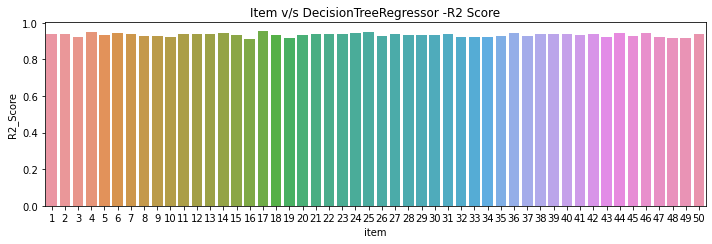

In [ ]:
result_x=result.item[result['Model_name']=='DecisionTreeRegressor']
result_y=result.R2_Score[result['Model_name']=='DecisionTreeRegressor']
plt.title('Item v/s DecisionTreeRegressor -R2 Score')
plt.xlabel('Item')
plt.ylabel('R2 Score')
sns.barplot(result_x,result_y)

Lets Predict the 90_days_Sales for each item with its Best_Model.

In [ ]:

best_model_item_wise=result[result['is_Best_model']=='Yes'][['item','Model']]
predicted_results=[]
for item in range(1,51):
  X_test=X_test_list[item-1]
  y_test=y_test_list[item-1]
  Best_Model=best_model_item_wise.Model[best_model_item_wise['item']==item].values[0]  
  y_pred=Best_Model.predict(X_test)
  d=pd.DataFrame(columns=['item','Sales_90_days_Actaul','Sales_90_days_Predicted'])  
  d['Sales_90_days_Actaul']  =y_test.astype(int)
  d['Sales_90_days_Predicted']  =y_pred.astype(int)
  d['item']=item
  predicted_resuls=predicted_results.append(d)

predicted_results[0]


,item,Sales_90_days_Actaul,Sales_90_days_Predicted
1388,1,18635,18756
1389,1,18545,18492
1390,1,18486,18475
1391,1,18420,18534
1392,1,18413,18555
...,...,...,...
1731,1,20796,20092
1732,1,20704,20052
1733,1,20642,20036
1734,1,20578,19858


From this Model, Manufacturers can predict their next 90 days Sales, and Based on that they can manfufacture their products to avoid the Loss.